This notebook picks a bunch of healpix pixels, and renders a nice picture of it

In [31]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp
import images
import NFW

import astropy.cosmology as cosmology

import multiprocessing as mp

import galsim
import meds

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.render.icl as icl
import synthetic.render.shear as shear

In [2]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [3]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

In [4]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])

In [5]:
pixel_id = 0

In [6]:
alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

In [7]:
pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

# This is the pre injection canvas

In [8]:
pixel_scale = 0.264
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = table["ra"]
mock_catalog["DEC"] = table["dec"]
mock_catalog["X"] = (table["ra"] - ra_cen) * 60 * 60 / pixel_scale + 2499.5
mock_catalog["Y"] = (table["dec"] - dec_cen) * 60 * 60 / pixel_scale + 2499.5

mock_catalog["MAG_I"] = table["mag_i"]
mock_catalog["TSIZE"] = table["size_true"]
mock_catalog["FRACDEV"] = 0
mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
mock_catalog["G1"] = table["ellipticity_1_true"]
mock_catalog["G2"] = table["ellipticity_2_true"]

In [9]:
def make_mock(table, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    pixel_scale = 0.264
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"]
    mock_catalog["FRACDEV"] = 0
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]    
    return mock_catalog

def radec2xy(ra, dec, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    x = (ra - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    y = (dec - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]
    return x.values, y.values

In [10]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

In [11]:
len(table) / (0.1 * 60)**2.

378.6666666666667

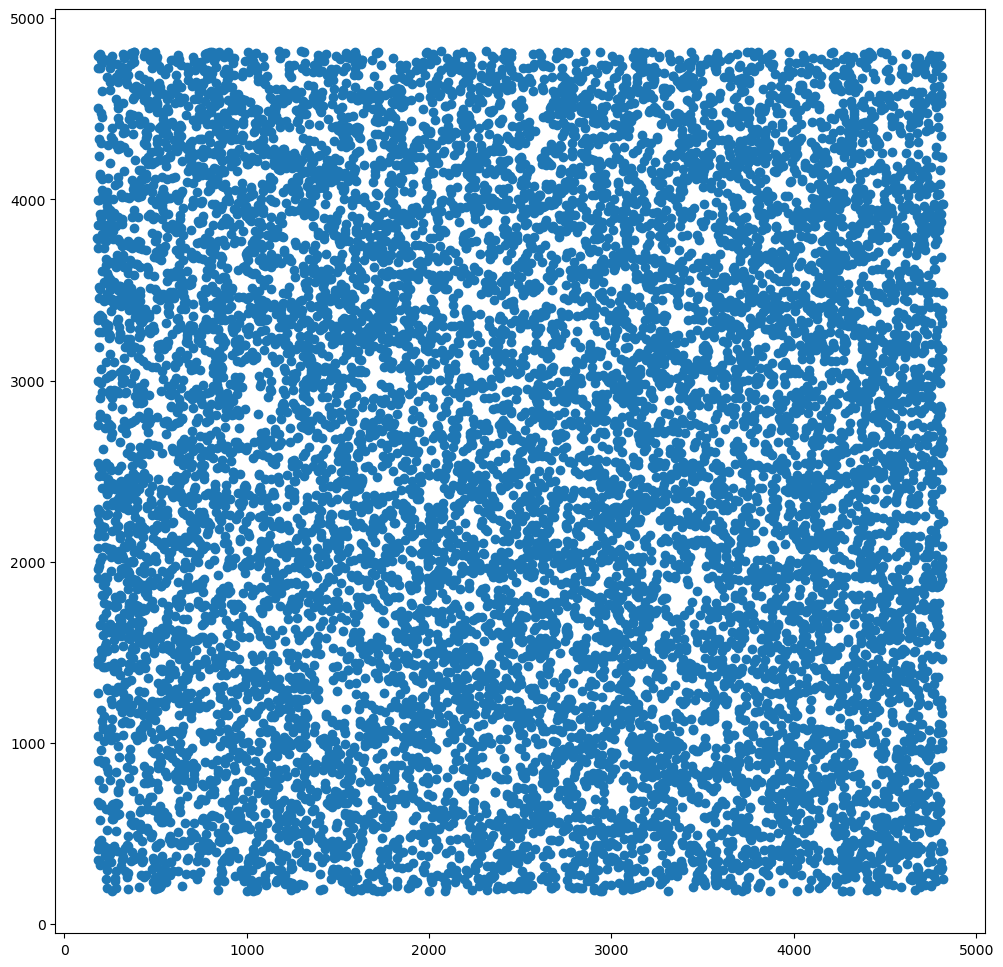

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [154]:
5000 / 0.264 / 60

315.65656565656565

In [13]:
# stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
# for i, band in enumerate(("g", "r", "i")):
#     name = folder_path + 'test_canvas_grid_' + band
#     print(name)
#     fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
#                      center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
#     fr.render() 

In [14]:
# ims_all = []
# for i, band in enumerate(("g", "r", "i")):
#     name = folder_path + 'test_canvas_grid_' + band + ".fits"
#     tmp = fio.read(name)
#     print(name)
#     ims_all.append(tmp)

In [15]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111)
# factor = 0.01
# scales = np.array([1., 1.2, 2.5]) * factor
# nonlinear = 0.12
# clip = 0

# pad = 0
# obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
#                                 ims_all[1],# + ims_icl[1] + noises[1] + pad,
#                                 ims_all[0],# + ims_icl[0] + noises[0] + pad,
#                                 nonlinear=nonlinear, clip=clip, scales=scales)  
# print(obs_im.max())
# ax.imshow(obs_im * 2, origin='upper')

# # ax.set_title("cluster + field rendered together")

# ax.set_xlabel("X [pix]")
# ax.set_ylabel("Y [pix]")
# fig.savefig("dc2_hp.png", bbox_inches='tight')

Let's look at the most masive 10 halos in more detail

In [16]:
# ihmaxes = np.argsort(table["halo_mass"])[::-1]

In [17]:
# masses = table["halo_mass"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
# ras = table["ra"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
# decs = table["dec"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
# xh, yh = radec2xy(ras, decs, sky_center=(ra_cen, dec_cen))

In [18]:
# marker_sizes = (np.log10(masses).values - 12.6) ** 4 * 30

In [19]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111)
# factor = 0.01
# scales = np.array([1., 1.2, 2.5]) * factor
# nonlinear = 0.12
# clip = 0

# pad = 0
# obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
#                                 ims_all[1],# + ims_icl[1] + noises[1] + pad,
#                                 ims_all[0],# + ims_icl[0] + noises[0] + pad,
#                                 nonlinear=nonlinear, clip=clip, scales=scales)  
# print(obs_im.max())
# ax.imshow(obs_im * 2, origin='upper')
# ax.scatter(xh[::-1], yh[::-1], s=marker_sizes[::-1], color="white", marker="x")

# # ax.set_title("cluster + field rendered together")

# ax.set_xlabel("X [pix]")
# ax.set_ylabel("Y [pix]")
# fig.savefig("dc2_hp_halos_in_FOV.png", bbox_inches='tight')

# Making some normal strong Isothermal shears

In [20]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [21]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

xra = (mock_catalog['X'] - 2499.5) * 0.264 / 60 # arcmin
ydec = (mock_catalog['Y'] - 2499.5) * 0.264 / 60 # arcmin
dists = np.sqrt(xra**2 + ydec**2)
shears = np.sqrt(1 / dists  / 400) # just for illustration purposes
shears[shears > 0.8] = 0.8

phis =  np.arctan2(ydec, xra)
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))
mock_catalog["G1"] = es1
mock_catalog["G2"] = es2

# dists = np.sqrt((mock_catalog["RA"] - ra_cen)**2 + (mock_catalog["DEC"] - dec_cen)**2)
# shears = np.sqrt(1 / (dists * 30)  / 3) # just for illustration purposes
# shears[shears > 0.8] = 0.8

# phis =  np.arctan2(mock_catalog["DEC"], mock_catalog["RA"])
# es1 = (-1. * shears * np.cos(2 * phis))
# es2 = (-1. * shears * np.sin(2 * phis))

# mock_catalog["G1"] = es1
# mock_catalog["G2"] = es2

# e1 = mock_catalog["G1"]
# e2 = mock_catalog["G2"]

# vals1 = e1 + es1 - e1 * es1 - e2 * es2
# vals2 = e2 + es2 - es1 * e2 + es2 * e1

# tmp = np.sqrt(vals1**2. + vals2**2.)
# ii = tmp > 0.95
# divs = 1. / (0.1 + tmp[ii])  
# vals1[ii] *= divs
# vals2[ii] *= divs

# mock_catalog["G1"] = vals1
# mock_catalog["G2"] = vals2

## This is where we test the tangential shear profile

In [22]:
def get_tangential(xpos, ypos, e1, e2, center):
    """The center is where th aperture is"""
    dists = np.sqrt((ypos - center[1])**2. + (xpos - center[0])**2.)
    phis = np.arctan2(ypos - center[1], xpos - center[0])
    tshears = -e1 * np.cos(2 * phis) - e2 * np.sin(2 * phis)
    return tshears, dists

In [23]:
tshear, rarr = get_tangential(mock_catalog["X"], mock_catalog["Y"], es1, es2, (2499.5, 2499.5))

Text(0, 0.5, '$\\gamma_t$')

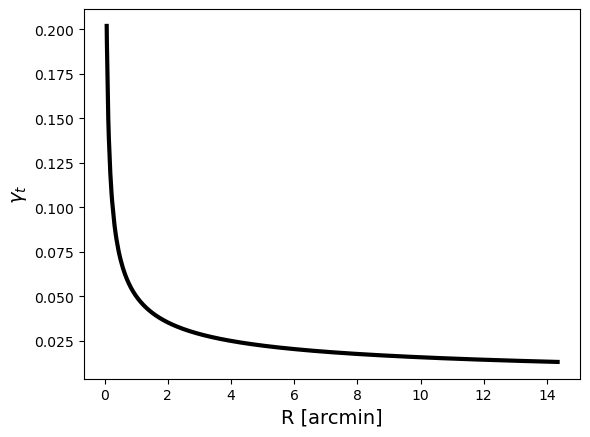

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\\gamma_t$", fontsize=14)

Text(0, 0.5, '$\\gamma_t$')

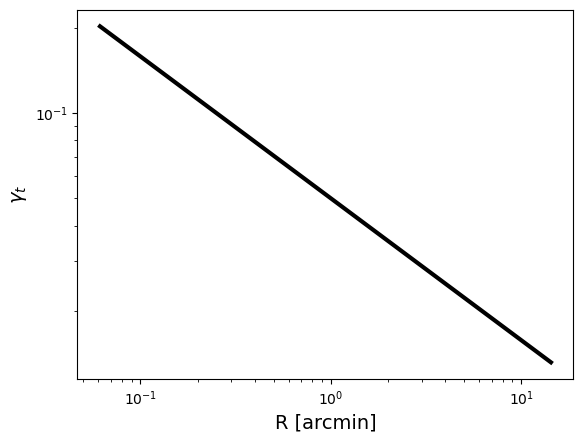

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\\gamma_t$", fontsize=14)

# Adding a cluster from the curated selection

In [99]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_001.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [100]:
galpath = "../galsim/ICL/evolving_red_gal.dat"
mstarpath = "../galsim/ICL/mstar_des_i03.fit"
jk_profile_root = "../galsim/ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": -0.1356766444194723,
    "g2":0.0345231539560347,
    "imag": 17.76,
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45
z = 0.3

In [101]:
di = icl.DrawICL(mas s, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
ims_icl = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/icl.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((arr - pos) * k))


## Rendering and detecting

In [102]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_v2_canvas_grid_low-isothermal_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_i
starting xshear calculations in 100 processes


In [103]:
catalog_cluster = data[data['LOC'] == 1]
catalog_cluster["X"] -= 2501.5
catalog_cluster["Y"] -= 2501.5

In [104]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) *1e-5 # This should be noise free
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_v2_clust_canvas_grid_low-isothermal_' + band
    print(name)
    fr = frame.Frame(catalog_cluster, band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_i
starting xshear calculations in 100 processes


In [105]:
ims_field = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_v2_canvas_grid_low-isothermal_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_field.append(tmp)
    
ims_clust = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_v2_clust_canvas_grid_low-isothermal_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_clust.append(tmp)    

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_i.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_i.fits


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9374293684959412


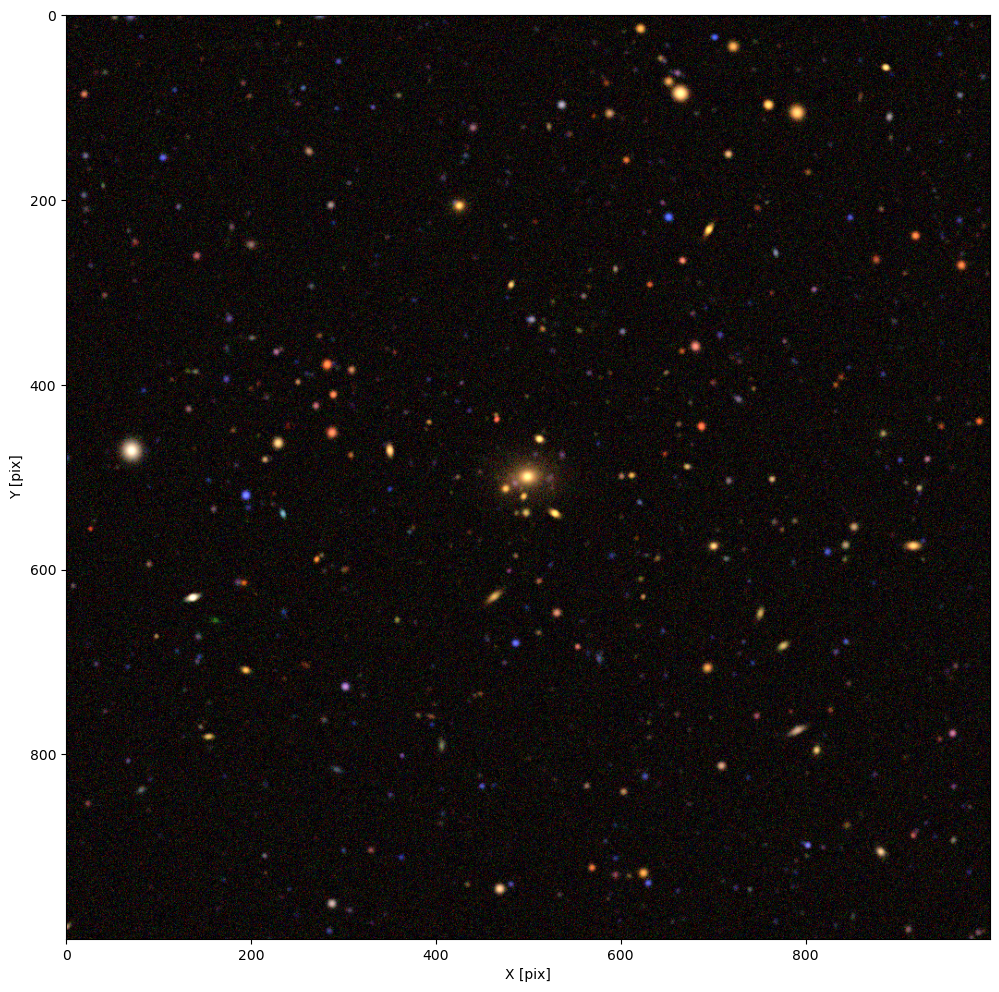

In [118]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_field[2] + ims_clust[2] + ims_icl[2] + pad,
                                ims_field[1] + ims_clust[1] + ims_icl[1] + pad,
                                ims_field[0] + ims_clust[0] + ims_icl[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2000:3000, 2000:3000] * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp_clust.png", bbox_inches='tight')

## Render a deeper mock coadd and run sextractor

In [125]:
name = folder_path + 'test_v2_canvas_grid_low-isothermal_coadd_' + 'i'
print(name)
fr_field = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=5000)
fr_field.render() 
fr_field.extract()

noise = np.ones(shape=(fr.canvas_size, fr.canvas_size))
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i
starting xshear calculations in 100 processes
sex /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i.fits -c config.sex -CATALOG_NAME /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i_cat.fits -CHECKIMAGE_NAME /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i_seg.fits


In [117]:
name = folder_path + 'test_v2_clust_canvas_grid_low-isothermal_coadd_' + "i"
print(name)
fr_clust = frame.Frame(catalog_cluster, band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1e-5, canvas_size=5000)
fr_clust.render() 
# fr_clust.extract()

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_clust_canvas_grid_low-isothermal_coadd_i
starting xshear calculations in 100 processes


In [120]:
fr_all = copy.deepcopy(fr_field)
fr_all.canvas += fr_clust.canvas
fr_all.canvas += ims_icl[2]
fr_all.name = folder_path + 'test_v2_field+clust+icl_canvas_grid_low-isothermal_coadd_' + "i"
fr_all.write()

In [122]:
fr_all.extract()

sex /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_field+clust+icl_canvas_grid_low-isothermal_coadd_i.fits -c config.sex -CATALOG_NAME /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_field+clust+icl_canvas_grid_low-isothermal_coadd_i_cat.fits -CHECKIMAGE_NAME /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_field+clust+icl_canvas_grid_low-isothermal_coadd_i_seg.fits


In [108]:
# noise = np.random.normal(scale=fr.noise_std, size=(fr.canvas_size, fr.canvas_size))
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size))
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

In [128]:
fr_field.name

'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i'

## re-running

# Create MEDS file

In [130]:
ii = fr_field.scat["MAG_AUTO"] < 23
objects = fr_field.scat[ii]

In [131]:
nimage = 1
nobj = len(objects)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = objects['NUMBER']

box_sizes = np.round(objects["A_IMAGE"] * objects["B_IMAGE"] * 2 ) *2
box_sizes[box_sizes < 16] = 16
obj_data['box_size'] = box_sizes

obj_data['ra'] = objects['ALPHAWIN_J2000'] + 0.264 / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['dec'] = objects['DELTAWIN_J2000'] - 0.264 / 3600
obj_data['X_IMAGE'] = objects['X_IMAGE']
obj_data['Y_IMAGE'] = objects['Y_IMAGE']

In [132]:
path_image = fr_all.name + ".fits"
path_weight = fr_field.name + "_weight.fits"
path_seg = fr_field.name + "_seg.fits"

path_length= np.max((len(path_image), len(path_seg), len(path_weight)))

image_info= meds.util.get_image_info_struct(nimage, path_length)

image_info['image_path'][0] = path_image
image_info['weight_path'][0] = path_weight
image_info['seg_path'][0] = path_seg
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

In [133]:
import psfex

# row=514.25
# col=610.00
pex = psfex.PSFEx("../meds/star_canvas_cat.psf")
# image = pex.get_rec(row, col)
psf_data = [pex,]
# psf_data = [mpex]

In [134]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)
mm.write(folder_path + "canvas_v2_all_low-isothermal.meds")

writing cutouts for: ['image', 'weight', 'seg']
file    1 of    1: 'b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_field+clust+icl_canvas_grid_low-isothermal_coadd_i.fits''
    first cut:    2900 of   2900 objects
    second cut:   2900 of   2900 objects
2900/2900 had ncut > 0
setting start rows and pixel count
total pixels: 1736804
setting psf layout for PSFEx
meds layout build time: 0.186728 seconds
opening output MEDS file: '/e/ocean1/users/vargatn/LSST/SYNTHETIC/canvas_v2_all_low-isothermal.meds'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


    reserving psf mosaic
writing image cutouts
    1/1 image b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_field+clust+icl_canvas_grid_low-isothermal_coadd_i.fits'
    no background for image
writing weight cutouts
    1/1 weight b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i_weight.fits'
writing seg cutouts
    1/1 seg b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_v2_canvas_grid_low-isothermal_coadd_i_seg.fits'
writing psf cutouts
output is in: /e/ocean1/users/vargatn/LSST/SYNTHETIC/canvas_v2_all_low-isothermal.meds


In [135]:
m = meds.MEDS(folder_path + "canvas_v2_all_low-isothermal.meds")

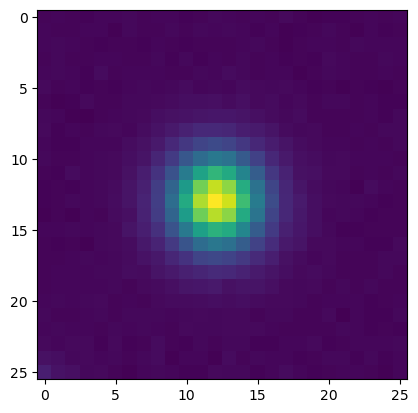

In [136]:
im = m.get_cutout(1623, 0, 'image')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)

# Running metacal

In [138]:
input_name = folder_path + "canvas_v2_all_low-isothermal.meds"

In [139]:
outfile_names = folder_path + "canvas_v2_all_low-isothermal_mcal" # file name root of output (will have additional _01 _02 etc appended to it)
maxnum = len(objects) # The highest number of  objects to include from the sextractor detection catalog. 


infodicts = mcal.infomaker(maxnum, input_name, outfile_names, nchunk=100)

In [140]:
mcal.multi_mcal(infodicts, nprocess=100)

starting metacal calculations in 100 processes
    failure: s2n_sum <= 0.0 : 0.0
Total fitting and stacking time: 30.536041736602783 seconds
Total fitting and stacking time: 31.210721969604492 seconds
Total fitting and stacking time: 31.79915475845337 seconds
Total fitting and stacking time: 32.21091604232788 seconds
Total fitting and stacking time: 32.308758020401 seconds
Total fitting and stacking time: 32.44144654273987 seconds
Total fitting and stacking time: 32.49430704116821 seconds
Total fitting and stacking time: 32.638221740722656 seconds
Total fitting and stacking time: 32.73999524116516 seconds
Total fitting and stacking time: 32.78369331359863 seconds
Total fitting and stacking time: 33.03455090522766 seconds
Total fitting and stacking time: 33.10466456413269 seconds
Total fitting and stacking time: 33.58531308174133 seconds
Total fitting and stacking time: 33.589375734329224 seconds
Total fitting and stacking time: 33.586514472961426 seconds
Total fitting and stacking time

In [146]:
tab = mcal.collater(infodicts)

In [147]:
tshear, rarr = get_tangential(tab["X_IMAGE"], tab["Y_IMAGE"],
                              tab["g_noshear"][:, 0], tab["g_noshear"][:, 1],
                              (2499.5, 2499.5))
rarr *= pixel_scale / 60

In [148]:
resp = (tab["r11"] + tab["r22"]) / 2

In [149]:
def binned_signal(rvals, shears, redges, resps=None):
    
    rcens = redges[:-1] + np.diff(redges) / 2.
    vals = np.zeros(len(rcens))
    vals_err = np.zeros(len(rcens)) # This is the error on the mean, not the std
    respvals = np.zeros(len(rcens))
    for i, tmp in enumerate(redges[:-1]):
        ii = np.where((rvals > redges[i]) & (rvals < redges[i + 1]))[0]
        vals[i] = np.mean(shears[ii])
        vals_err[i] = np.std(shears[ii]) / np.sqrt(len(ii))
        
        if resps is not None:
            respvals[i] = np.mean(resps[ii])
            
    return rcens, vals, vals_err, respvals
        
    

In [150]:
binned_signal(rarr, tshear, np.linspace(0, 14, 10), resp)

(array([ 0.77777778,  2.33333333,  3.88888889,  5.44444444,  7.        ,
         8.55555556, 10.11111111, 11.66666667, 13.22222222]),
 array([0.00246352, 0.02486716, 0.02231146, 0.02186484, 0.01829822,
        0.00655172, 0.01083328, 0.02885472, 0.00114764]),
 array([0.01883621, 0.00756852, 0.00646164, 0.00550009, 0.00444324,
        0.00414738, 0.00351358, 0.00744212, 0.00718956]),
 array([0.94818418, 0.79620681, 0.94113132, 0.7575332 , 0.83034118,
        0.80775288, 0.80658975, 0.74788685, 0.82219018]))

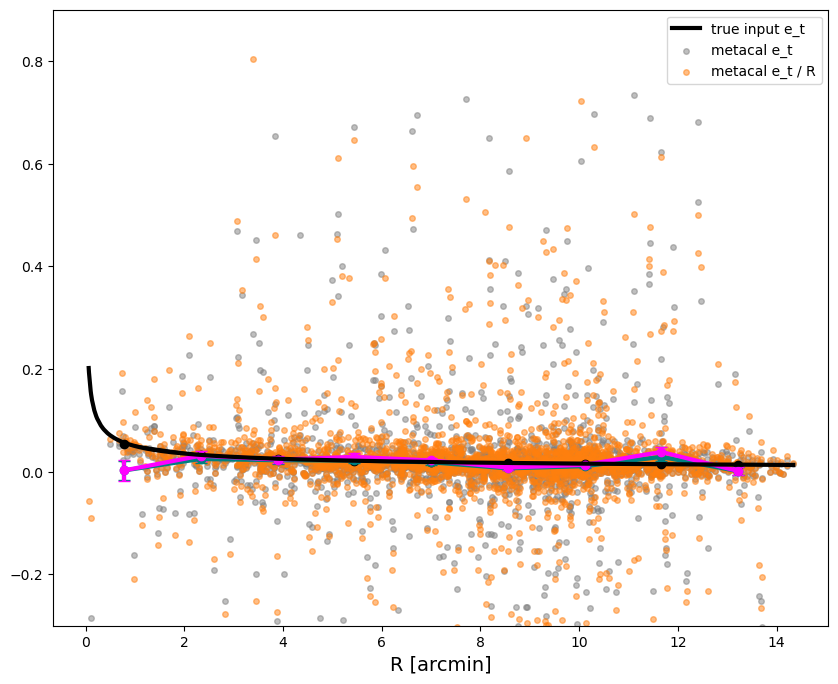

In [151]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")

redges = np.linspace(0, 14, 10)
rcens, strue, tmp = binned_signal(dists.iloc[iorder].values, shears.iloc[iorder].values, redges)[:-1]
ax.plot(rcens, strue, marker="o", color="black")


ax.scatter(rarr, tshear, s = 16, label="metacal e_t", color="gray", alpha=0.5)
ax.scatter(rarr, tshear / resp, s = 16, label="metacal e_t / R", color="C1", alpha=0.5)

rcens, sraw, sraw_err = binned_signal(rarr, tshear, redges)[:-1]
ax.errorbar(rcens, sraw, sraw_err, marker="o", color="teal", lw=3, capsize=4)

rcens, sraw, sraw_err, respvals = binned_signal(rarr, tshear, redges, resp)
ax.errorbar(rcens, sraw / respvals, sraw_err / respvals, marker="o", color="magenta", lw=3, capsize=4)

ax.set_ylim(-0.3, 0.9)
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_xlabel("R [arcmin]", fontsize=14)

ax.legend()

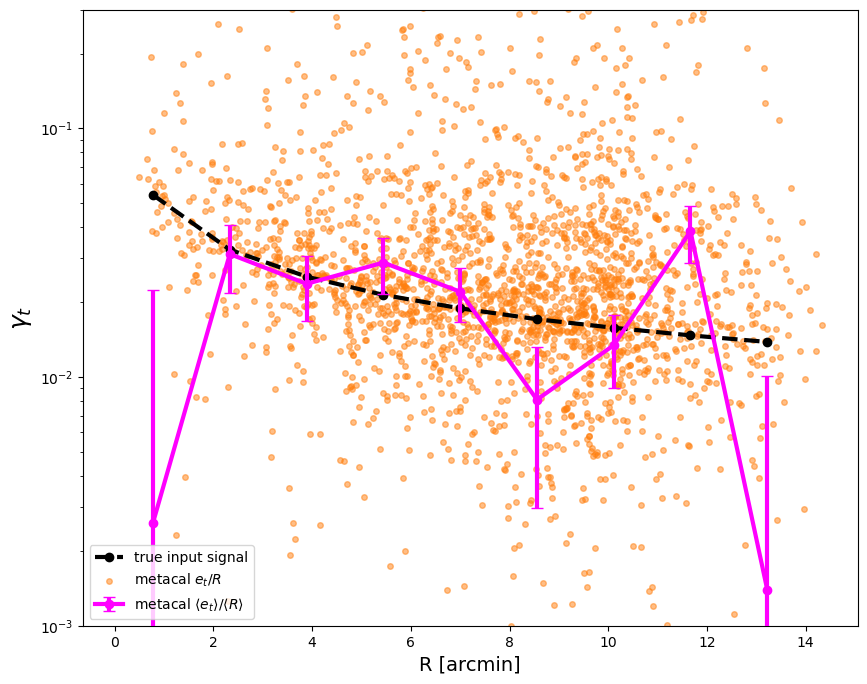

In [152]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# plot the truth curve
# iorder = np.argsort(dists)
# ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")

redges = np.linspace(0, 14, 10)
rcens, strue, tmp = binned_signal(dists.iloc[iorder].values, shears.iloc[iorder].values, redges)[:-1]
ax.plot(rcens, strue, marker="o", color="black", lw=3, ls="--", label="true input signal")


ax.scatter(rarr, tshear / resp, s = 16, label="metacal $e_t / R$", color="C1", alpha=0.5)


rcens, sraw, sraw_err, respvals = binned_signal(rarr, tshear, redges, resp)
ax.errorbar(rcens, sraw / respvals, sraw_err / respvals, label="metacal $\\langle e_t \\rangle / \\langle R \\rangle$",
            marker="o", color="magenta", lw=3, capsize=4, zorder=5)

ax.set_ylim(0.001, 0.3)
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\gamma_t$", fontsize=18)
ax.set_yscale("log")
ax.legend()
fig.savefig("metacal_clust_low-isothermal_cartoon_v01.png", bbox_inches="tight")

In [162]:
2900 / (4 * 14 * 14)

3.6989795918367347

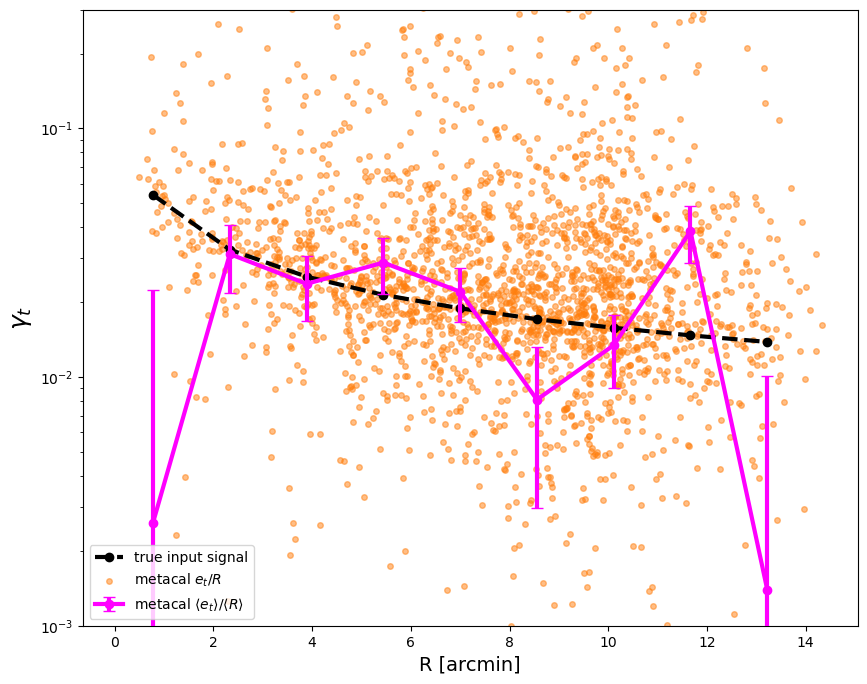

In [161]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# plot the truth curve
# iorder = np.argsort(dists)
# ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")

redges = np.linspace(0, 14, 10)
rcens, strue, tmp = binned_signal(dists.iloc[iorder].values, shears.iloc[iorder].values, redges)[:-1]
ax.plot(rcens, strue, marker="o", color="black", lw=3, ls="--", label="true input signal")


ax.scatter(rarr, tshear / resp, s = 16, label="metacal $e_t / R$", color="C1", alpha=0.5)


rcens, sraw, sraw_err, respvals = binned_signal(rarr, tshear, redges, resp)
ax.errorbar(rcens, sraw / respvals, sraw_err / respvals, label="metacal $\\langle e_t \\rangle / \\langle R \\rangle$",
            marker="o", color="magenta", lw=3, capsize=4, zorder=5)

ax.set_ylim(0.001, 0.3)
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\gamma_t$", fontsize=18)
ax.set_yscale("log")
ax.legend()
fig.savefig("metacal_clust_low-isothermal_cartoon_v01.png", bbox_inches="tight")